# Introduction to Reinforcement Learning (RL) in PyTorch

### Recap of Supervised Learning

So far, we've primarily concerned ourselves with supervised learning problems (mostly classification).
In supervised learning, we are given some sort of training data consisting of input/output pairs, with the goal being to be able to predict the output given some new inputs after learning the model.
For example, we previously looked at a Convolutional Neural Network (CNN) classification model for MNIST; given a training set of 60000 digit images and corresponding digit labels (e.g. '5'), we learned a model that was capable of predicting the digit label of new MNIST images.
In order words, something like (but not exactly) this:
<img src="Figures/mnist_cnn_ex.png" alt="mnist_cnn_ex" style="width: 500px;"/>

What if we want to learn how to perform more complex behaviors, where data collection can be expensive? 
How do you teach a robot to walk? 
Self-driving cars? 
How do you defeat human champions in the game of Go? 

### Reinforcement Learning
Enter Reinforcement Learning. 
In Reinforcement Learning, our model (commonly referred to as an *agent* in this context) interacts with an *environment* by taking *actions* $a$ and receives some sort of feedback from the environment in the form of a *reward* $r$. 
In this sense, reinforcement learning algorithms learn by experience.
We call the trajectory of going from start to finish of a task an *episode*, and often our agent will learn by undergoing many episodes.
<img src="Figures/RL.PNG" alt="RL" style="width: 300px;"/>

Many reinforcement learning algorithms are modeled as Markov Decision Processes (MDPs). 
In these settings, we have a concept of a *state* $s$, which encapsulates the situation of the agent (e.g. location, velocity).
From each state $s_t$, the agent takes an action $a_t$, which results in a transition from one state $s_t$ to another $s_{t+1}$.
In many settings, there is stochasticity in this transition, meaning that there's is a distribution over $s_{t+1}$ conditioned on $s_t$ and $a_t$.
Often, several of these states are considered episode ending, after which the agent can no longer make any transitions or collect any more reward.
These correspond to states such as reaching the final goal, a game concluding, or falling of a cliff.
In the end, our goal is to learn a *policy* $\pi$, or a mapping from states to actions.

In an MDP, we assume that we can always tell which state $s_t$ our agents is in.
However, this isn't always the case.
Sometimes, all we have access to are observations $o_t$ that provide information the state $s_t$, but enough to precisely pinpoint the exact one.
We call such settings Partially Observable Markov Decision Processes (POMDPs).
Imagine for example a [Roomba](https://en.wikipedia.org/wiki/Roomba) being trained to navigate a living room with RL.
From its infrared and mechanical "bump" sensors, it receives partial information ($o_t$) as to where it might be, but not a definitive location ($s_t$).
Operating as a POMDP adds a whole layer of complexity to RL algorithms.
For the rest of day though, we'll focus on MDPs, as their much simpler and easier to use to teach basic concepts.


#### A simple MDP example

<img src="Figures/MDP.png" alt="MDP" style="width: 400px;"/>


In the above example, we can see the 3 possible states for the agent as $s_0$, $s_1$, and $s_2$, with 2 actions $a_0$ and $a_1$ available from each state.
We can see that the each action doesn't lead to a determinstic transition to the next state, as shown by multiple paths from each action. 
Note that each of the outcomes of an action are labeled with a small black number between 0 and 1.
This denotes the probability of that outcome (which state we end up at) given the the action; as these are probabilites, the sum of the probabilities of arriving at each of the next states $s_{t+1}$ given a previous state $s_t$ and selected action $a_t$ is 1.

#### Objective

The goal of the agent is to maximize the total reward $R$ it can receive over some number of steps.
It is important to ensure the reward actually captures the true goal we want the agent to achieve.
The agent will dutifully attempt maximize the objective it is given, without any considerations to any implicit objectives that a human may desire.
There are more than a few (amusing) anecdotes of RL agents learning undesirable behaviors by exploiting some aspect of the reward function.
As such, defining this reward requires special care.

One countermeasure commonly deployed by RL researchers is the concept of *discounted* rewards.
This is done with a multiplicative term $\gamma$: a reward $T$ steps in the future is discounted as $\gamma^T r_T$.
Using discounting encourages the agent to finish the task sooner rather than later, a common implicit criterion.
With discounting then, the RL agent's goal is to maximize:
\begin{align*}
\mathbb{E}[\sum_{t=0}^{\infty} \gamma^t r_t]
\end{align*}
This is far from the complete solution to making our rewards accurately capture our desired objectives, but achieving higher rewards sooner rather than later is an almost universal preference, so we almost always add it.
Designing a good reward function can be an art is highly dependent on the task.

#### Reinforcement Learning as Supervised Learning?
At first, this doesn't seem too different from the supervised methods we've looked at before, and some natural questions might arise:
- Why can't we just treat RL as a supervised task? 
Why can't we use the reward (or rather, the negative of the reward) as our supervised loss?

Unlike in supervised learning, in reinforcement learning, we often don't have a pre-apportioned dataset to learn from.
In some problems set-ups, we may have examples of other agents (oftentimes humans) performing the desired task, but these aren't necessarily optimal examples of how to maximize the reward, which is what we want to learn.
In most RL settings, we don't have any examples of state-action trajectories beyond what our agent experiences through trial-and-error, which are even more suboptimal.


### Open AI Gym
Before we dive any deeper into implementing reinforcement learning models, first we need an environment.
Remember, the goal is to learn an agent that can interact with an environment in the way we want, so we need something that our agent can interact with and receive rewards from.
In robotics, this is often the real world (or some set-up in the real world).
However, it is oftentimes cheaper and quicker to first test our algorithms in simulated settings.
There are a number of tasks that are popular benchmarks for the reinforcement learning community, such as [cart pole](https://en.wikipedia.org/wiki/Inverted_pendulum), [mountain car](https://en.wikipedia.org/wiki/Mountain_car_problem), or [Atari 2600 games](https://gym.openai.com/envs/#atari). 
In the spirit of accelerating progress and promoting openness in the research community, Open AI has very nicely coded up [Open AI Gym](https://gym.openai.com/), which has implementations of many of these environments for public use.
We will be using these environments, as it allows us to focus on the algorithms themselves, instead of worrying about implementing each problem setting ourselves.

To use it, we first need to download and install it. Make sure you're in your PyTorch environment first!

```Shell
# If you environment isn't currently active, activate it:
# conda activate pytorch

pip install gym
```

Once it's installed, we can import it like any other Python module:

In [2]:
import gym

### FrozenLake (a Grid World)

Let's start with a simple environment: FrozenLake.
Here's the official description from OpenAI gym:

> *Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.*

A visualization of FrozenLake as a grid world:

<img src="Figures/FrozenLake.PNG" alt="FrozenLake" style="width: 400px;"/>

At the start of an episode, we begin in the upper left corner (S).
Our goal is to move ourself to the lower right corner (G), avoiding falling into the holes (H).
Icy water is cold.

In reinforcement learning terms, each of the 16 locations on the grid are a state, and an action is attempting to move in one of four directions (left, down, right, up).
Each move will result in the agent's state changing from $s_t$ to $s_{t+1}$ as it changes location, unless it attempts to move in the direction of a wall, which results in the agent's state not changing (the agent doesn't move).
We receive a positive reward of "+1" for reaching the goal (G), discounted according to how long it took.
While there is not a negative reward for falling into a hole (H), the agent still pays a penalty in the sense that falling into the hole is episode-ending and therefore prevents it from receiving any reward. 
We want to learn a policy $\pi$ that takes us from our starting location (S) to the goal (G) in as few steps as possible.

To really establish what we are trying to accomplish here, it's worth debunking a few common initial misconceptions:

- **Knowledge of the states and transition probabilties:** From the top-down view, your first thought might be to plot out a path from the start to the finish, just as you would with a maze.
However, this view is provided to us the algorithm designers so we can visualize the problem at hand.
The agent learning the task does *not* get this prior knowledge; all we are about to tell it is that there are going to be 16 states and 4 possible actions from each state.
A more proper analogy would be if I blindfolded you and dropped you in the middle of a frozen lake, and told you your state (location) every time you decided to take a step in one of four directions, then set off fireworks when you stepped on the frisbee.

- **Knowledge of the goal (reward):** In OpenAI's official description of the environment, you (the agent) know what you're hoping to accomplish: You want to retrieve the frisbee, while avoiding falling through the ice.
The agent does *not* know this.
Rather, it learns the goal by experiencing rewards (or penalties), and the algorithm updates its policy such that it will be more (or less) likely to do those actions again.
Note that this means that if an agent never experiences certain rewards, it won't know they exist.

- **Prior knowledge of pathfinding, physics, etc.:** As a human, even if you haven't solved this task before, you still bring a tremondous amount of prior knowledge to this problem.
For example, you know the shortest path to a destination is a line.
You know that North, South, East, and West, are directions, and that going North and then South brings you back to where you already were.
You know ice is slippery.
You know icy water is cold.
You know being in icy cold water is bad.
It's important to keep in mind that our agent will begin knowing none of these things; it's initial policy is essentially picking actions completely at random.
By the end of the training, it still won't know what abstract concepts like "North/South," "cold," or "slippery" mean, but it will have (hopefully) learned a good policy that allows it to complete the goal.

#### Interacting with FrozenLake
This example is simple enough that we could code the environment and its interface ourselves fairly easily, but OpenAI has already done it, and we'd like to focus on the algorithm of solving it as much as possible.
We can create an instantiation of FrozenLake in a single line of code:

In [3]:
env = gym.make('FrozenLake-v0')

Open AI Gym environments provide a mechanism to observe the state of the environment, and since FrozenLake is an MDP (as opposed to POMDP), the observation is the state itself.
For FrozenLake, there are 16 grid locations on the map, meaning we have 16 states.
We can confirm this by looking at the size of the `observation_space` attribute for the environment we just created.

In [4]:
env.observation_space

Discrete(16)

Our agent will interact with this environment causing its state to change.
For FrozenLake, we have 4 options, each corresponding to attempting to step in a particular direction: `[Left, Down, Right, Up]`.
We can confirm this by looking at the size of the `action_space` of our environment.

In [5]:
env.action_space

Discrete(4)

Before interacting with the environment, we have to first reset it to initialize it. 
Resetting also returns an observation of the first state after resetting.
In FrozenLake, we always start in the upper left corner, which corresponds to state 0.
As such, we see the `reset()` command returning `0`.

In [6]:
env.reset()

0

We can visualize the FrozenLake environment by calling `render()`. 
In more complex tasks this will actually add frames to a video showing our agent's progress, but for FrozenLake, it just prints out a text representation, with the highlighted character showing our agent's current location.
We can see that we started in the upper-left corner, on the "S," as promised.

In [7]:
env.render()


SFFF
FHFH
FFFH
HFFG


Now, let's try moving.
On thing to keep in mind is that the original FrozenLake environment is "slippery." 
Because of the ice, if you try to go in one direction, you end up with a 1/3 chance of going in the direction you meant and the two adjacent directions each. 
For example, if we try going right, we have equal probabilities of slipping and going up and down instead.
This makes things a little more complicated, so for now, let's first turn off the stochasticity and make this a deterministic transition instead.
We do this by registering a new type of environment, and then instantiating a copy of said environment, making sure to reset it first.

In [8]:
# Non-slippery version

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)
env = gym.make('FrozenLakeNotSlippery-v0')
env.reset()

0

We advance time in an OpenAI environment with the `step()` method, which takes as argument an `action`.
Let's trying moving right, which corresponds to action `2`.
Notice that the output is a tuple of four elements: the next observation (`object`), the reward (`float`), whether or not the episode is done (`boolean`), and a dictionary of information (`dict`) that may be useful for debugging (this dict shouldn't be used in the final algorithm itself).

In [9]:
env.step(2)

(1, 0.0, False, {'prob': 1.0})

Next, let's `render()` to visualize what happened.
Observe that this particular environment prints out the action we took in parentheses up top, in this case "(Right)", and then shows the result of that action.
Notice that while most of the time, we succeed in going in the direction we want to, occasionally we slip on the ice and go in a direction we didn't intend.

In [10]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


We can keep doing this as many times as we want.
Since we're in Jupyter, we can just keep running the same cell (making small edits to change our action).

Notice that once we fall into a hole, the episode is over, and we can no longer do anything.
The same is true after reaching the goal.

In [11]:
env.step(0)
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


Before we get into any RL, let's see how random actions perform in this environment:

In [12]:
env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
env.render()


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


Hm. 
Not great. 
Alright, so clearly picking random steps isn't very likely to take us to the goal.
It's apparent just from looking at the map that there're much better policies that we can learn.
How are we going to do so?

#### Q-learning
There are many algorithms that we can use, but let's choose Q-learning, which we covered earlier today.
Remember, in Q-learning (and SARSA, it turns out), we're trying learn the Q values for the states in our system.

The Q value for a policy $\pi$ is a function of the state $s$ and action $a$ and is defined as the following:
\begin{equation}
Q_\pi (s,a) = \mathbb{E}\big[\sum_{t=0}^{\infty} \gamma^t r_t \big|\pi, s_0 = s, a_0 = a\big]
\end{equation}
Intuitively, the Q value is the total reward (including discounting) that the agent will gain if it takes action $a$ from state $s$ and then follows policy $\pi$ for the rest of the episode.
As one might expect, if Q is known exactly, the agent will attain the highest reward from $s$ if the policy $\pi$ is to pick the $a$ with the highest Q value.

Okay, so if we know the Q values for the system, then we can trivially find the optimal policy.
So what are the Q values of the system?
Well, at the beginning, we don't know, but we can try to learn them through experience.
This is where Q-learning comes in.
Q-learning iteratively updates the Q values in the following way:
\begin{equation}
Q_\pi (s_t, a_t) \leftarrow (1 - \alpha) \cdot Q_\pi(s_t, a_t) + \alpha \cdot \big(r_t + \gamma \max_a Q_\pi(s_{t+1}, a)\big)
\end{equation}
Notice that Q-learning is an *off-policy* method, in the sense that you don't actually learn from the trajectory you actually took (otherwise it'd be SARSA).
Instead, we learn from the *greedy* transition, i.e. the best action we know how to take.

And that's it! 
We run our agent through many episodes, experiencing many $s_t \rightarrow a_t \rightarrow s_{t+1}$ transitions and rewards, and just like that, we eventually learn a good Q function (and thus a good policy).
Now of course, there are a bunch of small details and tweaks to make this work in practice, but we'll get to those later.

#### Q-learning in FrozenLake
FrozenLake is a very simple setting, one that we would call a toy problem.
With only 16 states and 4 actions, there are only 64 state-action pairs possible (16x4=64), less if we account for the goal and the holes being episode ending (for simplicity though, we won't). 
With this few state-action pairs, we can actually solve this problem tabularly.
Let's set up a Q table, and initialize the Q-values for all state-action pairs to zeros.
Note that while we could, we're actually not going to need PyTorch in this example; PyTorch's autograd and neural network libraries are unnecessary here, as we're only going to be modifying a table of numbers.
Instead, we'll use a Numpy array to store the Q table.

In [13]:
import numpy as np

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

A few hyperparameters we're going to set:
- `alpha`: learning rate for the Q function
- `gamma`: discount rate for future rewards
- `num_episodes`: number of episodes (trajectories from start to goal/hole) our agent will learn from

We're also going to store our rewards in an array called `rs`.

In [14]:
# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

Now for the bulk of algorithm itself.
Notice that we're going to loop through the process `num_episodes` times, resetting the environment each time.
At each step, we take the action with the highest Q value for our current state, with some randomness added in (especially at the beginning) to encourage exploration.
After each action, we update our Q table greedily based on the reward experienced and the next best action.
We also make sure to update our state, rinse, and repeat. 
We continue taking actions in an episode until it is `done`, storing the final total reward for the episode.

In [15]:
for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False
    
    #Reset environment and get first new observation
    s = env.reset()
    
    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))
        
        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)
        
        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))
        
        # Add reward to episode total
        r_sum_i += r*gamma**t
        
        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

How did we do?
Let's take a look at the rewards that we saved.
We can plot the reward versus the episode number, and hopefully we'll see some sort of an increase over time.
RL performance can be extremely noisy, so let's instead plot a moving average.

In [16]:
rs

array([0.        , 0.        , 0.        , ..., 0.77378094, 0.77378094,
       0.77378094])

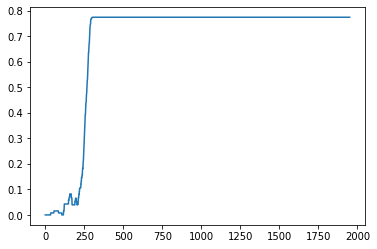

In [17]:
## Plot reward vs episodes
import matplotlib.pyplot as plt

# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0)) 
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

Pretty good.
We might also be interested in how often our agent actually reached the goal.
This won't account for how quickly the agent got there (which might also of interest), but let's ignore that for now.
To prevent us from being overwhelmed by data points, let's bucket the values into 10 stages, printing out how many episodes of each stage resulted in finding the goal.

In [18]:
# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)
    
print("Rewards: {0}".format(num_Gs))

Rewards: [  6. 126. 200. 200. 200. 200. 200. 200. 200. 200.]


Our RL agent does a really good job at navigating the FrozenLake when its moves are deterministic, but after all, this is
supposed to be *Frozen*Lake, so where's the fun without the slipperiness?
Let's go back to the original environment and see how the agent does.

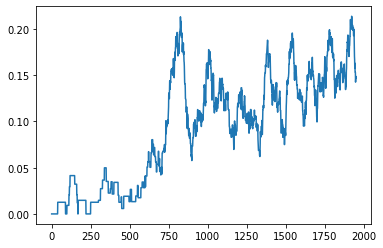

Rewards: [  5.   6.   8.  41.  97.  96.  80. 111. 115. 126.]


In [19]:
env = gym.make('FrozenLake-v0')

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False
    
    #Reset environment and get first new observation
    s = env.reset()
    
    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))
        
        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)
        
        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))
        
        # Add reward to episode total
        r_sum_i += r*gamma**t
        
        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

## Plot reward vs episodes
# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0)) 
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)
    
print("Rewards: {0}".format(num_Gs))

Much harder.
However, we can see that the model does eventually learn something.

### PyTorch in RL
Hey, not bad.
However, while the previous example was fun and simple, it was noticeably lacking any hint of PyTorch.

We could have used a PyTorch `Tensor` to store the Q table, but that's not any better than using a NumPy array.
PyTorch's true utility comes from building neural networks and calculating/applying gradients automatically, which learning the Q table didn't need. 

#### Continuous domains
In our previous example, we mentioned that with only 16 discrete states and 4 actions/state, the Q table only needed to hold 64 values, which is very manageable.
However, what if the state or action space is continuous?
You could discretize it, but then you have to pick a resolution, and your state-action space could explode exponentially.
Treating these binned states or actions as completely different states is also ignoring that two consecutive bins are likely very similar in the needed policy.
You can learn these relationships, but doing so is horriby sample inefficient.

Instead of learning a Q table then, perhaps a Q function would be more appropriate.
This function would take in a state and action as an input and return a Q value as an output.
The Q function may be very complex, but as we've learned over the past few days, neural networks are very flexible and good for approximating arbitrary functions.
[Deep Q Networks](https://deepmind.com/research/dqn/) take such an approach.

### Cart Pole

Let's look at the cart pole problem next. 
In this setting, we have a pole attached to a hinge on a cart, with the goal being to keep the pole vertical as long as possible, without traveling too far along the rail.
Because of gravity, the pole will fall unless the cart is exactly beneath the the pole's center of gravity.
To prevent the pole from falling, the agent can apply a force of +1 or -1 to the cart to move it left and right along a track.
The agent receives a reward of +1 for every timestamp the pole remains vertical; the game ends when the pole fall past 15 degrees from vertical or the cart moves more than 2.4 units away from the center.
We're going to somewhat arbitrarily call "success" achieving a reward of +200; alternatively, the agent needs to avoid the aforementioned failure conditions for 200 ticks.

<img src="Figures/polebalance.gif" alt="polebalance" style="width: 400px;"/>

First, let's create an instance of the cart pole environment:

In [20]:
env = gym.make('CartPole-v0')

Again, we can look at the `observation_space` for this environment.
Also similar to FrozenLake, since this version of cart pole is an MDP (as opposed to POMDP), the observation is the state itself.
We can see that the states for cart pole have 4 dimensions, which correspond to `[cart position, cart velocity, pole angle, pole angular velocity]`.
Importantly, notice these states are *continuous* values.

In [26]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

We can look at the `action_space` again too.
In cart pole, there are two actions available to the agent: `[apply force left, apply force right]`.
We can see this by examining the `action_space` attribute:

In [27]:
env.action_space

Discrete(2)

Resetting the environment returns our first observations, which we can see has 4 values corresponding to the 4 previously mentioned state variables.

In [31]:
env.reset()

array([-0.0357068 ,  0.04089538, -0.03120365, -0.00508663])

Before we get into any reinforcement learning, let's see how we perform actions within the environment.

In [32]:
done = False

while not done:
#     env.render()
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)

Okay, so clearly choosing a random action at every time step doesn't really achieve our goal of keeping the pole vertical.
We're going to need something smarter.

Let's close that rendering window.
We do this with `close()`.
Note that `gym` renderings can be a little finicky, especially on Windows; either `close()` or restarting your Jupyter kernel may be necessary to close the rendered window.

In [33]:
env.close()

Cart pole is actually a fairly simple problem (it's very low dimensional), and so there are simpler ways to do this, but since we've been having so much fun with deep learning, let's use a neural network.
Specifically, let's build a DQN that uses Q-learning to learn how to balance the pole.
We're going to give our DQN agent 1000 episodes to try and reach the goal of 200 ticks.

There are a lot of small details that go into making these models work well, so instead of going through it piece by piece, the full code:

In [34]:
# Based on: https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/

from collections import deque
import random
import math

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, 2)

    def forward(self, x):        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x        
    

class DQNCartPoleSolver:
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.dqn = DQN()
        self.criterion = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.dqn.parameters(), lr=0.01)

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return torch.tensor(np.reshape(state, [1, 4]), dtype=torch.float32) 
    
    def choose_action(self, state, epsilon):
        if (np.random.random() <= epsilon):
            return self.env.action_space.sample() 
        else:
            with torch.no_grad():
                return torch.argmax(self.dqn(state)).numpy()

    def remember(self, state, action, reward, next_state, done):
        reward = torch.tensor(reward)
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        y_batch, y_target_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y = self.dqn(state)
            y_target = y.clone().detach()
            with torch.no_grad():
                y_target[0][action] = reward if done else reward + self.gamma * torch.max(self.dqn(next_state)[0])
            y_batch.append(y[0])
            y_target_batch.append(y_target[0])
        
        y_batch = torch.cat(y_batch)
        y_target_batch = torch.cat(y_target_batch)
        
        self.opt.zero_grad()
        loss = self.criterion(y_batch, y_target_batch)
        loss.backward()
        self.opt.step()        
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                if e % 100 == 0 and not self.quiet:
#                     self.env.render()
                    pass
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

if __name__ == '__main__':
    agent = DQNCartPoleSolver()
    agent.run()
    agent.env.close()

[Episode 0] - Mean survival time over last 100 episodes was 13.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 20.18 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 41.95 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 83.92 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 122.03 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 171.42 ticks.
Ran 565 episodes. Solved after 465 trials ✔


Reinforcement learning can be kind of noisy.
In some sense, it depends on your agent "lucking" into the right behavior so that it can learn from it, and occasionally one can get stuck in a bad rut.
Even if your agent fails to "solve" the problem (i.e. reach 200 ticks), you should still see the mean survival time mostly climbing as the agent experiences more episodes.
You may need to re-run learning a couple times for the agent to reach 200 ticks.

Want to take this farther and connect this with the convolutional neural networks we've previously learned about?
See [here](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) for a version of Cartpole where instead of directly measuring the translation/rotational position/velocity, the agent only sees the rendered screen.
This makes the problem much harder, as the agent needs to learn to infer translation/rotational position/velocity from images.

### Other materials:
Reinforcement Learning can easily be a full course (or multiple) on its own at most universities, with or without deep learning.
We only touch on a couple points here.
If you're interested in *exploring* this field further, a few recommendations to get you started:

- [The definitive textbook on Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)
- [Video lectures by David Silver](https://www.youtube.com/playlist?list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ)
- [Deep Q-Networks (DQN) for Atari 2600 games](https://deepmind.com/research/dqn/) 
- [Popular blog post on using policy gradients to learn to play Pong from pixels](http://karpathy.github.io/2016/05/31/rl/)